In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None
plt.style.use('seaborn')  # 이미지가 seaborn스타일로 나온다. 
sns.set(font_scale=2)

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
root = '/content/drive/MyDrive/data/instacart-market-basket-analysis/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [2]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,user_product_reorder_percentage,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,...,total_reorders_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1,order_diff
0,1.0,196,0.899902,10.0,9.0,1.400391,19.562500,10.0,1.0,1.0,...,41.0,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
1,1.0,10258,0.888672,9.0,8.0,3.333984,19.562500,10.0,1.0,1.0,...,41.0,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
2,1.0,10326,0.000000,1.0,0.0,5.000000,28.000000,5.0,NaN,NaN,...,41.0,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,6.0
3,1.0,12427,0.899902,10.0,9.0,3.300781,19.562500,10.0,1.0,1.0,...,41.0,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
4,1.0,13032,0.666504,3.0,2.0,6.332031,21.671875,10.0,1.0,NaN,...,41.0,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0


유저 id와 product_id는 뺀다.

In [3]:
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [5]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

X = df[x_cols]
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


0.0    5734377
1.0     621618
Name: reordered, dtype: int64

# 레이블 분포 확인

In [7]:
y.shape

(8474661,)

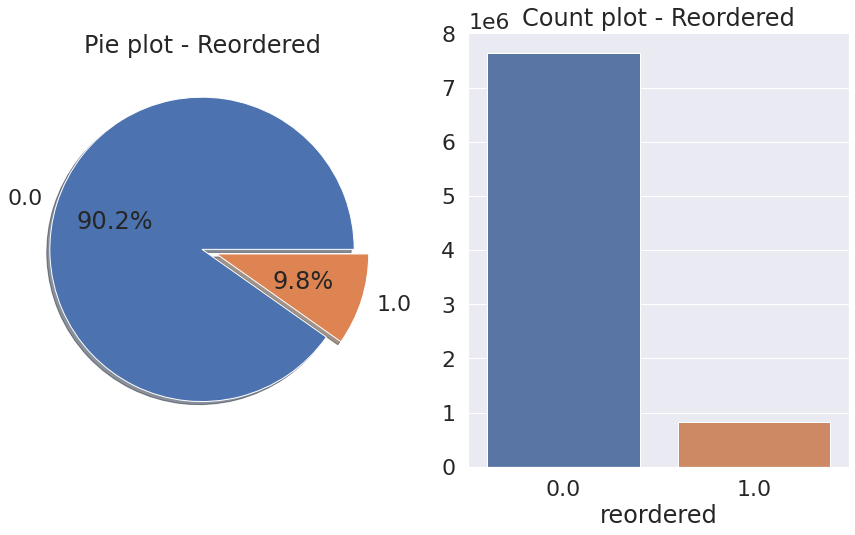

In [35]:
# 타겟 레이블 분포 확인
f,ax =plt.subplots(1, 2, figsize=(15, 8))

y.value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Reordered')
ax[0].set_ylabel('')

sns.countplot(x='reordered', data=df, ax=ax[1])
ax[1].set_title('Count plot - Reordered')
plt.show()

# 따로 EDA 해보기

# 모델 생성 및 학습/예측/평가

In [39]:
# 검증을 위한 매트릭스 함수

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

# 모델과 데이터를 받아서 학습/예측/평가하는 함수 정의
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [40]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimatiors=1000, num_leaves=64, n_jobs=1, boost_from_average=False)    
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

오차 행렬
[[1889766   21694]
 [ 168021   39185]]
정확도: 0.9105, 정밀도: 0.6437, 재현율: 0.1891, F1: 0.2923, AUC: 0.8354


In [ ]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

## feature importance

In [ ]:
fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, ax = ax)